# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [ ]:
!pip -q install ./python

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [ ]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

##For local windows implementation
env = UnityEnvironment(file_name='C:/Users/adamb/OneDrive/Documents/Udacity Reinforcement Learning/3. Policy Base Methods/p2_continous_control/Reacher_Windows_x86_64/Reacher')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

# 5. Initial Implementation 

In [ ]:
##Not required for local implementations
#!pip -q install ./python

In [1]:
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt
import datetime

from unityagents import UnityEnvironment
from model import Actor, Critic
from ddpg_agent import Agent, OUNoise, ReplayBuffer

In [2]:
%matplotlib inline

In [3]:
##Instantiate environment
# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

##For local windows implementation
env = UnityEnvironment(file_name='C:/Users/adamb/OneDrive/Documents/Udacity Reinforcement Learning/3. Policy Base Methods/p2_continous_control/Reacher_Windows_x86_64/Reacher')


# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
##Get 'environment' variables
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]

Number of agents: 1
Size of each action: 4


In [6]:
##Instantiate Agent
agent = Agent(state_size = state_size, action_size = action_size, random_seed=10)

In [7]:
def ddpg_train(n_episodes=200, max_t=200, print_every=10, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores_deque = deque(maxlen=print_every)
    scores = []
    reward_avg = []
    
    scores_avg = []
    
    eps = eps_start
    
    for i_episode in range(1, n_episodes+1):
        agent.reset()
        
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        #states = env_info.vector_observations
        score = 0
        #score = np.zeros(num_agents)

        reward_temp = 0
        steps = 0
        #print(i_episode)
        
        for t in range(max_t):
            steps += 1
            ##Determine action to take with clipping
            action = agent.act(state, eps, add_noise=True)
            #actions = agent.act(states, add_noise=False)
            
            ##Execute action
            env_info = env.step(action)[brain_name]
            #env_info = env.step(actions)[brain_name]
            
            ##Get results of action
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]                  
            done = env_info.local_done[0]  
            #next_states = env_info.vector_observations
            #rewards = env_info.rewards
            #dones = env_info.local_done
        
            ##Update agent
            agent.step(state, action, reward, next_state, done)
            #agent.step(states, actions, rewards, next_states, dones)
            
            ##Save scores
            score += reward
            #score += env_info.rewards
            
            state = next_state
            #states = next_states
            
            if done:
                break
            #if np.any(dones):
            #    break
        
        eps = max(eps_end, eps_decay*eps)
        
        print(datetime.datetime.now())
        print('Score: ' + str(score))
        reward_avg.append(score / steps)
        
        #reward_avg += [sum(reward_temp) / len(reward_temp)]
        
        scores_deque.append(score)
        scores.append(score)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        
        scores_avg.append(np.mean(scores_deque))
        #print(reward_avg)
        print()
        

    return scores, reward_avg, scores_avg

In [8]:
scores, reward_avg, scores_avg = ddpg_train(n_episodes=500, max_t=500, print_every=20, eps_start=1.0, eps_end=0.01, eps_decay=0.995)

C:\Users\adamb\Anaconda3\envs\testenv4\lib\site-packages\torch\nn\functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


2020-02-05 20:50:12.955637
Score: 0.0
Episode 1	Average Score: 0.00


C:\Users\adamb\OneDrive\Documents\Udacity Reinforcement Learning\3. Policy Base Methods\p2_continous_control\ddpg_agent.py:101: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


2020-02-05 20:50:23.479286
Score: 0.0
Episode 2	Average Score: 0.00
2020-02-05 20:50:34.230347
Score: 0.0
Episode 3	Average Score: 0.00
2020-02-05 20:50:45.009860
Score: 0.0
Episode 4	Average Score: 0.00
2020-02-05 20:50:55.803466
Score: 0.06999999843537807
Episode 5	Average Score: 0.01
2020-02-05 20:51:06.766785
Score: 0.0
Episode 6	Average Score: 0.01
2020-02-05 20:51:17.599861
Score: 0.0
Episode 7	Average Score: 0.01
2020-02-05 20:51:28.442975
Score: 0.0
Episode 8	Average Score: 0.01
2020-02-05 20:51:39.302235
Score: 0.0
Episode 9	Average Score: 0.01
2020-02-05 20:51:50.215419
Score: 0.2299999948590994
Episode 10	Average Score: 0.03
2020-02-05 20:52:01.147671
Score: 0.0
Episode 11	Average Score: 0.03
2020-02-05 20:52:12.100534
Score: 0.0
Episode 12	Average Score: 0.02
2020-02-05 20:52:23.084252
Score: 0.3799999915063381
Episode 13	Average Score: 0.05
2020-02-05 20:52:33.986860
Score: 0.0
Episode 14	Average Score: 0.05
2020-02-05 20:52:44.892898
Score: 0.0
Episode 15	Average Score: 0

2020-02-05 21:10:39.429776
Score: 0.0
Episode 112	Average Score: 0.03
2020-02-05 21:10:50.708286
Score: 0.0
Episode 113	Average Score: 0.03
2020-02-05 21:11:01.906116
Score: 0.0
Episode 114	Average Score: 0.03
2020-02-05 21:11:13.074394
Score: 0.0
Episode 115	Average Score: 0.03
2020-02-05 21:11:24.239900
Score: 0.0
Episode 116	Average Score: 0.00
2020-02-05 21:11:35.415658
Score: 0.0
Episode 117	Average Score: 0.00
2020-02-05 21:11:46.623762
Score: 0.11999999731779099
Episode 118	Average Score: 0.01
2020-02-05 21:11:57.850060
Score: 0.0
Episode 119	Average Score: 0.01
2020-02-05 21:12:09.046993
Score: 0.0
Episode 120	Average Score: 0.01

2020-02-05 21:12:20.203940
Score: 0.0
Episode 121	Average Score: 0.01
2020-02-05 21:12:31.383654
Score: 0.0
Episode 122	Average Score: 0.01
2020-02-05 21:12:42.617020
Score: 0.0
Episode 123	Average Score: 0.01
2020-02-05 21:12:53.838968
Score: 0.0
Episode 124	Average Score: 0.01
2020-02-05 21:13:05.087296
Score: 0.0
Episode 125	Average Score: 0.01
202

2020-02-05 21:31:17.405245
Score: 0.0
Episode 221	Average Score: 0.11
2020-02-05 21:31:28.853266
Score: 0.19999999552965164
Episode 222	Average Score: 0.12
2020-02-05 21:31:40.407267
Score: 0.0
Episode 223	Average Score: 0.12
2020-02-05 21:31:51.834299
Score: 0.0
Episode 224	Average Score: 0.12
2020-02-05 21:32:03.313320
Score: 0.14999999664723873
Episode 225	Average Score: 0.12
2020-02-05 21:32:14.750336
Score: 0.18999999575316906
Episode 226	Average Score: 0.12
2020-02-05 21:32:26.185355
Score: 0.0
Episode 227	Average Score: 0.12
2020-02-05 21:32:37.677395
Score: 0.12999999709427357
Episode 228	Average Score: 0.09
2020-02-05 21:32:49.186437
Score: 1.0099999774247408
Episode 229	Average Score: 0.14
2020-02-05 21:33:00.642969
Score: 0.5399999879300594
Episode 230	Average Score: 0.14
2020-02-05 21:33:12.087968
Score: 0.0
Episode 231	Average Score: 0.14
2020-02-05 21:33:23.535011
Score: 0.5299999881535769
Episode 232	Average Score: 0.17
2020-02-05 21:33:34.999028
Score: 0.099999997764825

2020-02-05 21:50:44.689971
Score: 0.5399999879300594
Episode 323	Average Score: 0.52
2020-02-05 21:50:56.128541
Score: 0.18999999575316906
Episode 324	Average Score: 0.52
2020-02-05 21:51:07.570541
Score: 0.25999999418854713
Episode 325	Average Score: 0.54
2020-02-05 21:51:19.081582
Score: 0.2199999950826168
Episode 326	Average Score: 0.53
2020-02-05 21:51:30.559600
Score: 0.47999998927116394
Episode 327	Average Score: 0.47
2020-02-05 21:51:41.948618
Score: 0.9999999776482582
Episode 328	Average Score: 0.51
2020-02-05 21:51:53.369169
Score: 1.169999973848462
Episode 329	Average Score: 0.57
2020-02-05 21:52:04.853187
Score: 0.4599999897181988
Episode 330	Average Score: 0.59
2020-02-05 21:52:16.297779
Score: 0.8099999818950891
Episode 331	Average Score: 0.63
2020-02-05 21:52:27.772291
Score: 0.0
Episode 332	Average Score: 0.61
2020-02-05 21:52:39.218817
Score: 0.1699999962002039
Episode 333	Average Score: 0.60
2020-02-05 21:52:50.657346
Score: 0.0
Episode 334	Average Score: 0.56
2020-02-

2020-02-05 22:10:02.501448
Score: 1.7399999611079693
Episode 424	Average Score: 0.45
2020-02-05 22:10:13.951527
Score: 0.25999999418854713
Episode 425	Average Score: 0.46
2020-02-05 22:10:25.477622
Score: 0.47999998927116394
Episode 426	Average Score: 0.45
2020-02-05 22:10:36.907621
Score: 0.9499999787658453
Episode 427	Average Score: 0.50
2020-02-05 22:10:48.383658
Score: 1.099999975413084
Episode 428	Average Score: 0.52
2020-02-05 22:10:59.907799
Score: 1.9499999564141035
Episode 429	Average Score: 0.58
2020-02-05 22:11:11.485930
Score: 0.6099999863654375
Episode 430	Average Score: 0.60
2020-02-05 22:11:22.943459
Score: 0.18999999575316906
Episode 431	Average Score: 0.59
2020-02-05 22:11:34.410013
Score: 1.0599999763071537
Episode 432	Average Score: 0.64
2020-02-05 22:11:45.864545
Score: 0.029999999329447746
Episode 433	Average Score: 0.59
2020-02-05 22:11:57.365073
Score: 0.1699999962002039
Episode 434	Average Score: 0.56
2020-02-05 22:12:08.889411
Score: 0.25999999418854713
Episode

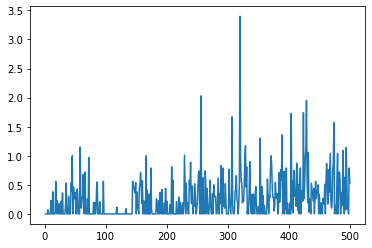

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)

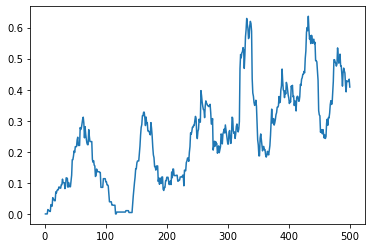

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_avg)+1), scores_avg)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()